Seminar 6: Hacking R-CNN
====================

**WARNING: This seminar was not thoroughly tested so expect weird bugs. Please report if you found one!**

In this assignment, you will hack the existing code for object detection (https://github.com/rbgirshick/py-faster-rcnn) in order to make it usable with **Theano**-based models.

Originally, Ross Girshick uses [Caffe](http://caffe.berkeleyvision.org/) as a backend for deep learning. This is not very good for us as Caffe is substantially different from Theano, and one cannot simply replace one framework with the other. Luckily, the training and the testing procedures are built on top of the [Python interface](http://caffe.berkeleyvision.org/tutorial/interfaces.html) (instead of the Caffe's native CLI+protobufs combo) which makes it possible to locate and exterminate Caffe-contaminated parts and fill the gaps with appropriate wrappers around Theano machinery.

While it sounds like an easy task, this surgery still requires good familiarity with the RCNN's internals, so you will have to go through the Rob's slides and the code and make sure that you understand what is happening in each of the modules.

In [1]:
import os
import sys
import scipy
import random
import theano
import lasagne
import numpy as np
import cPickle as pickle
import theano.tensor as T
import matplotlib.pyplot as plt

from IPython import display
from scipy.misc import imread, imsave, imresize
from sklearn.cross_validation import train_test_split
from custom import utils, models, net

%matplotlib inline

Using gpu device 0: Quadro K4200 (CNMeM is enabled with initial size: 10.0% of memory, CuDNN 4007)


R-CNN introduction
--------------------

In a nutshell, R-CNN is just a common image recognition neural network applied to patches that obtained by rescaling rectangular regions of a bigger scene. Those regions are usually computed externally using, for example, [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/). The overall pipeline is best described by the following slide from the Girshick's [awesome presentation](http://tutorial.caffe.berkeleyvision.org/caffe-cvpr15-detection.pdf):
<img src="notebook/img/rcnn_slide.jpg" width=600px><img>

You are encouraged to read the [relevant paper](http://www.cs.berkeley.edu/~rbg/papers/pami/rcnn_pami.pdf) to get deeper understanding of how the system works.

Setup the code
--------------------

### Cython modules

First, we need to build Cython modules that come with the original Faster R-CNN package.

In [20]:
!cd ./lib; make

python setup.py build_ext --inplace
running build_ext
skipping 'utils/bbox.c' Cython extension (up-to-date)
skipping 'nms/cpu_nms.c' Cython extension (up-to-date)
rm -rf build


### PASCAL VOC 2007

In our experiments, we are going to use [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) so we download training, validation and test data as well as VOCdevkit (**this may take a while!**). We are assuming you have the `wget` utility installed on your computer.

In [42]:
os.path.join('~/Projects/DeepLearning/seminar_6/downloads', 'VOCdevkit')

'~/Projects/DeepLearning/seminar_6/downloads/VOCdevkit'

In [46]:
# If you already have the dataset on your machine just put the absolute path (root path - w/o VOCdevkit) 
# into the following variable:
PASCALVOC2007_PATH='~/Projects/DeepLearning/seminar_6/downloads'

if not PASCALVOC2007_PATH:
    # You can change the download target path.
    PASCALVOC2007_PATH='./downloads'
    
    #!mkdir -p {PASCALVOC2007_PATH}
    #!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar {PASCALVOC2007_PATH}
    #!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar {PASCALVOC2007_PATH}
    #!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar {PASCALVOC2007_PATH}
    
    !cd {PASCALVOC2007_PATH}; tar xvf VOCtrainval_06-Nov-2007.tar
    !cd {PASCALVOC2007_PATH}; tar xvf VOCtest_06-Nov-2007.tar
    !cd {PASCALVOC2007_PATH}; tar xvf VOCdevkit_08-Jun-2007.tar
    
# We symlink the dataset path to the folder that is expected by the R-CNN code.
VOCDEVKIT_PATH = os.path.join(PASCALVOC2007_PATH, 'VOCdevkit')
!ln -f -s {VOCDEVKIT_PATH} ./data/VOCdevkit2007

### Region proposals

Next, you need to fetch some external region proposals. The original code uses Selective Search by default. You can download and setup this data by running the cell below. It is very time-consuming, so go have some coffee.

In [ ]:
# Alternatively, you can ask people who have already downloaded the data to share it. 
# Then you can just put it in the ./data folder and skip this step.
!data/scripts/fetch_selective_search_data.sh

Other option would be to use precomuted [RPN proposals](https://github.com/ShaoqingRen/faster_rcnn#resources). Fetch them from [here](https://yadi.sk/d/ENCF0DTXr323P) and unpack to the `./data` folder. The advantage of using them is that you only need **300** entities per image (instead of **2000**) to get a good performance.

### Pretrained base models

Finally, you need to download one of the pretrained NNs that we will use a starting point for our object detection pipeline. As we are using Lasagne, it's a good idea to check out [Lasagne's ModelZoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo). We suggest not to go crazy and use a moderately-sized model like `caffe_reference` (or even shallower). We all want to set the new state-of-the-art for Object Detection, but let's start small.

In [10]:
ll = lasagne.layers.InputLayer(shape=(None, 3, 227, 227), tag='13')

In [5]:
import cPickle

def load_obj(fname):
    try:
        f = file(fname, 'rb')
        loaded_obj = cPickle.load(f)
        f.close()
        return loaded_obj
    except Exception as e:
        print e
        return 0

In [55]:
# building caffe reference model and loading weights
ref_net = net.Net('caffe_reference.pkl')

In [48]:
p = theano.function([ref_net.inp], ref_net.prediction, allow_input_downcast=True) 

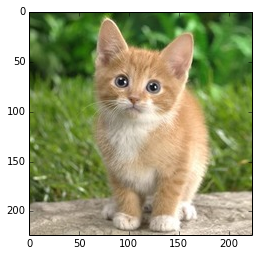

net thinks this is a tabby, tabby cat


In [64]:
# sanity check
img = imread('../seminar_5/sample_images/kitten.jpg')
classes = pickle.load(open('../seminar_5/classes.pkl'))
plt.imshow(img)
plt.show()

print 'net thinks this is a', classes[np.argmax(p(utils.preprocess(img, 227, 227)))]

yay

Write your modules
--------------------

The most interesting part of the assignment is, of course, the custom model injection. As we already mentioned, the original code uses Caffe. We (the TAs) did our best to get rid of this nasty dependency. **Now, spend some time comparing the code provided by us and the [Faster R-CNN repo](https://github.com/rbgirshick/py-faster-rcnn).** The code makes heavy use of the configuration files available by calling `from fast_rcnn.config import cfg`. The `cfg` contains various parameters that govern the behaviour of the whole system. The standard configuration is defined in `./lib/fast_rcnn/config.py`. In order to override it use `./experiments/cfgs/rcnn.yml`.

You'll have to
  1. Add missing pieces to `./lib/utils/train.py` (this is where the main training loop is).
  2. Implement the network (`./custom/net.py`) and the solver (`./custom/solver.py`) class respecting the interface described in the source files. **You are NOT required to code up the bounding-box regression.** 
  3. Repeat the steps above for two kinds of training regimes:
    - Fine-tuning of the top layer.
    - Fine-tuning of the whole network.
    
### Custom classes
  
The main purpose of the **`Net`** class is to hold a symbolic representation of your neural network. This is where you load a pretrained NN optionally modifying its architecture or weights.
 
The **`Solver`** is used to define actual training procedure:
  1. Create an instance of **`Net`**
  2. Define a loss function
  3. Define an optimization algorithm and its parameters
  4. Gather all of the above into the training step function
  
### ROIDataLayer

Your solver is likely to require some kind of training data source. In the orginial Girshick's code this data is obtained via **`ROIDataLayer`**. The **`ROIDataLayer`** takes care of the dataset management and produces tensors that are ready for the neural net processing. We are providing you with an adapted version of this layer suitable for incorporating into your custom modules. The typical usage is outlined below:

right

### Some tips
  1. Please **be careful with the input format**. Make sure that your network receives what it expects, i.e. check the order of color channels (`RGB`/`BGR`), range of values ($ [0, 1] $/ $ [0, 255] $), etc.
  2. Try Dropout to reduce overfitting.
  3. Try different optimization algorithms. `Adam` seems to require less tuning but may give slightly worse results than `SGD`.

Train model
--------------------

Now it's time to train your freshly written model. First, edit `./experiments/cfgs/rcnn.yml` to override the standard settings.

The training procedure is launched by invoking the following shell-command:

In [4]:
# just for illustration, I did not train the whole thing in IPython of course. 
NUM_ITERS=250

!./experiments/scripts/train_rcnn.sh {NUM_ITERS}

+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ ITERS=250
+ TRAIN_IMDB=voc_2007_trainval
++ date +%Y-%m-%d_%H-%M-%S
+ LOG=experiments/logs/rcnn.train.txt.2016-04-22_18-28-03
+ exec
++ tee -a experiments/logs/rcnn.train.txt.2016-04-22_18-28-03
tee: experiments/logs/rcnn.train.txt.2016-04-22_18-28-03: No such file or directory
+ echo Logging output to experiments/logs/rcnn.train.txt.2016-04-22_18-28-03
Logging output to experiments/logs/rcnn.train.txt.2016-04-22_18-28-03
+ ./tools/train_net.py --imdb voc_2007_trainval --iters 250 --cfg ./experiments/cfgs/rcnn.yml
Using gpu device 1: Quadro K4200 (CNMeM is enabled with initial size: 20.0% of memory, CuDNN 4007)
Called with args:
Namespace(cfg_file='./experiments/cfgs/rcnn.yml', imdb_name='voc_2007_trainval', max_iters=250, randomize=False, set_cfgs=None)
Using config:
{'DATA_DIR': '/home/aphex/Projects/DeepLearning/seminar_6/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'rcnn',
 'GPU_ID': 1,
 'MODELS_DIR': '/

Test model
--------------------

Let's asses the quality of trained model on the test set of PASCAL VOC 2007. In order to do this, you have to implement the **`Tester`** encapsulating a trained network. The **`Tester`**'s sole purpose is to produce confidence scores for bounding-boxes at, well, test time.

After the coding is done, the evaluation can be run by invoking:

In [8]:
# Put the path to the network snapshot here:
SNAPSHOT='/home/aphex/Projects/DeepLearning/seminar_6/output/rcnn/voc_2007_trainval/snapshot_iter_250.pkl'

!./experiments/scripts/test_rcnn.sh {SNAPSHOT}

+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ SNAPSHOT=/home/aphex/Projects/DeepLearning/seminar_6/output/rcnn/voc_2007_trainval/snapshot_iter_250.pkl
+ TEST_IMDB=voc_2007_test
++ date +%Y-%m-%d_%H-%M-%S
+ LOG=experiments/logs/rcnn.test.txt.2016-04-22_18-52-52
+ exec
++ tee -a experiments/logs/rcnn.test.txt.2016-04-22_18-52-52
tee: experiments/logs/rcnn.test.txt.2016-04-22_18-52-52: No such file or directory
+ echo Logging output to experiments/logs/rcnn.test.txt.2016-04-22_18-52-52
Logging output to experiments/logs/rcnn.test.txt.2016-04-22_18-52-52
+ ./tools/test_net.py --snapshot /home/aphex/Projects/DeepLearning/seminar_6/output/rcnn/voc_2007_trainval/snapshot_iter_250.pkl --imdb voc_2007_test --cfg ./experiments/cfgs/rcnn.yml
Using gpu device 1: Quadro K4200 (CNMeM is enabled with initial size: 20.0% of memory, CuDNN 4007)
Called with args:
Namespace(cfg_file='./experiments/cfgs/rcnn.yml', comp_mode=False, imdb_name='voc_2007_test', max_per_image=100, set_cfgs=

The test set is rather large (**4952** images) so it may take some time for the evaluation to finish. Just like in any serious ML research, it's a good idea to leave this thing running overnight.

Write a short report
--------------------

Please be advised that while I did my best to infer what exactly do I have to do, the result still MIGHT not be completely alligned with what was expected.

Anyways, that's what I've done so far:
1. put 2 CNN models (architectures + weights) from ModelZoo - CaffeReference and GoogleNet, in models.py
2. completed net.py module to provide interface to the said model
3. created some helper modules in utilities.py (as such, a function that produces a (128, 3, 227, 227) tensor for each RoI data layer batch.
4. completed SolverWrapper class for the
5. Solver class 

Solver class is initialised with a Net() instance and a prepared roidb instance from SolverWrapper. RoI_data_layer and step_function are also initialised. I only used SGD for optimization. In the get_training_batch I recieve top tensors from RoI_data_layer. Then, for each picture, I extract RoI cropped and resized regions of the image - thus producing X =(128, 3, 227, 227) tensor for each picture. I tried to use maximum batch size which my GPU could accomodate - that was 128 pictures. I used crossentropy between X and true labels as loss function. I tried attaching a 21-node fc layer to both fc7 and fc8 layers of the original CaffeReference network - fc7 turned out to yield much better accuracy.

Then, I started training the model. Without any regularization, it quickly converged to 75% accuracy - obviously that happened due to the fact that 75% of all classes are background (0), so the model just learnt to output all zeros. To overcome that, I employed regularization. I tried inserting DropOut in between different layers of the net. Ultimately, the best result was obtained with a p=0.2 DropOut between fc7 and fc8. In 1000 iterations, the model converged to ~0.01 loss (see log above). Overall, I trained the network for 5k iterations or so. Also, it seems that increasing the batch size has a positive effect on training. I did multiple training runs, loading the last weights from file every time.

Testing is running now, I will update the notebook when it finishes.

Describe the model that you use for this assignment. How do you train it? What did work and what didn't? **Most importantly, does fine-tuning of the whole network work any better than just adapting the last layer?**

If things are slow for you (advanced stuff)
--------------------

Then you are welcome to replace an older R-CNN pipeline with a newer **Fast R-CNN** approach (see [this paper](http://arxiv.org/abs/1504.08083) and, again, [this presentation](http://tutorial.caffe.berkeleyvision.org/caffe-cvpr15-detection.pdf)). The only missing piece is the so-called **ROI Pooling**. Fortunately, you can find a Theano implementation [here](https://github.com/ddtm/theano-roi-pooling) (**it's still somewhat untested**). Roughly speaking, you need to do the following:
  1. Wrap the Theano Op into a Lasagne's custom layer (see http://lasagne.readthedocs.org/en/latest/user/custom_layers.html).
  2. Change your network to receive two inputs (the whole image(s) and a set of rois - those are available through `ROIDataLayer`) instead of stack of patches of a fixed-size.